In [ ]:
CITY_GRAPH_FILES = {
    "Boston": [
        "Boston_Massachusetts_USA.graphml",
    ],
    "Chicago": [
        "Chicago.graphml",
        "Chicago_Illinois.graphml",
        "Chicago_Illinois_USA.graphml",
    ],
    "Dallas": [
        "Dallas_Texas_USA.graphml",
    ],
    "Phoenix": [
        "Phoenix_Arizona_USA.graphml",
    ],
    "Pittsburgh": [
        "Pittsburgh.graphml",
        "Pittsburgh_Pennsylvania.graphml",
        "Pittsburgh_Pennsylvania_USA.graphml",
        "Pittsburgh_Allegheny_County_Pennsylvania_United_States.graphml",
    ],
    "San Francisco": [
        "San_Francisco_California_USA.graphml",
    ],
}


In [1]:
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

# -----------------------------
# GLOBAL SETTINGS
# -----------------------------
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

ox.settings.log_console = False
ox.settings.use_cache = False

GRAPH_DIR = "/Users/surabhiraghavan/Documents/Sem 3/Network Science and Analysis/urban-mobility/backend/graphs"

# -----------------------------
# GRAPH LOADER
# -----------------------------
def load_city_graph(city):
    key = city.lower().replace(" ", "_")
    files = [f for f in os.listdir(GRAPH_DIR) if key in f.lower() and f.endswith(".graphml")]
    files.sort(key=len)

    path = os.path.join(GRAPH_DIR, files[0])
    print(f"Loading {city}: {files[0]}")

    G = ox.load_graphml(path)
    if "crs" not in G.graph or G.graph["crs"] is None:
        G = ox.project_graph(G)

    u, v, k, d = list(G.edges(keys=True, data=True))[0]
    if "travel_time" not in d:
        G = ox.add_edge_speeds(G)
        G = ox.add_edge_travel_times(G)
        ox.save_graphml(G, path)

    return G

# -----------------------------
# BASELINE STATS
# -----------------------------
def compute_baseline_stats(G):
    Gu = nx.Graph(G)

    deg = np.array([d for _, d in Gu.degree()])
    sample = random.sample(list(Gu.nodes()), min(500, Gu.number_of_nodes()))
    subG = Gu.subgraph(sample)
    if not nx.is_connected(subG):
        subG = subG.subgraph(max(nx.connected_components(subG), key=len))

    bridges = list(nx.bridges(Gu))

    return {
        "nodes": Gu.number_of_nodes(),
        "edges": Gu.number_of_edges(),
        "density": nx.density(Gu),
        "avg_degree": deg.mean(),
        "aspl": nx.average_shortest_path_length(subG),
        "clustering": nx.average_clustering(Gu),
        "assortativity": nx.degree_assortativity_coefficient(Gu),
        "bridge_fraction": len(bridges) / Gu.number_of_edges(),
    }

# -----------------------------
# PRECOMPUTATION (KEY SPEEDUP)
# -----------------------------
def precompute_city_data(G):
    print("  Precomputing betweenness + bridges")

    Gu = nx.Graph(G)

    # Approximate edge betweenness ONCE
    bc = nx.edge_betweenness_centrality(
        Gu, k=100, seed=RANDOM_SEED
    )

    bridges = set(nx.bridges(Gu))

    # Fixed OD pairs for fairness + speed
    nodes = list(G.nodes())
    od_pairs = [tuple(random.sample(nodes, 2)) for _ in range(100)]

    return bc, bridges, od_pairs

# -----------------------------
# EDGE FILTERS
# -----------------------------
def eligible_edges(G, scenario, bridges):
    edges = list(G.edges(keys=True, data=True))

    if scenario in ["Random Failure", "Targeted Attack (Top k%)"]:
        return [(u, v, k) for u, v, k, _ in edges]

    if scenario == "Bridge Collapse":
        return [(u, v, k) for u, v, k, _ in edges if (u, v) in bridges or (v, u) in bridges]

    if scenario == "Tunnel Closure":
        return [(u, v, k) for u, v, k, d in edges if d.get("tunnel") in ["yes", True]]

    if scenario == "Highway Flood":
        return [(u, v, k) for u, v, k, d in edges if d.get("highway") in ["motorway", "primary", "trunk"]]

    return []

# -----------------------------
# EDGE SELECTION
# -----------------------------
def select_edges(G, scenario, severity, bc, bridges):
    edges = eligible_edges(G, scenario, bridges)
    if not edges:
        return []

    k = max(1, int(len(edges) * severity))

    if scenario in ["Random Failure", "Tunnel Closure", "Highway Flood"]:
        return random.sample(edges, min(k, len(edges)))

    # Targeted
    ranked = sorted(
        edges,
        key=lambda e: bc.get((e[0], e[1]), 0),
        reverse=True
    )

    return ranked[:k]

# -----------------------------
# SIMULATION
# -----------------------------
def simulate_failure(G, scenario, severity, bc, bridges, od_pairs):
    Gf = G.copy()
    Gf.remove_edges_from(select_edges(G, scenario, severity, bc, bridges))

    ratios = []
    disconnected = 0

    for o, d in od_pairs:
        try:
            t0 = nx.shortest_path_length(G, o, d, weight="travel_time")
            tf = nx.shortest_path_length(Gf, o, d, weight="travel_time")
            ratios.append(tf / t0)
        except nx.NetworkXNoPath:
            disconnected += 1

    avg_ratio = np.mean(ratios) if ratios else np.inf
    pct_disc = disconnected / len(od_pairs)
    resilience = np.exp(-avg_ratio) * (1 - pct_disc)

    return avg_ratio, pct_disc, resilience

# -----------------------------
# RUN EXPERIMENT
# -----------------------------
cities = ["Boston", "Chicago", "Dallas", "Phoenix", "Pittsburgh", "San Francisco"]
scenarios = [
    "Random Failure",
    "Targeted Attack (Top k%)",
    "Bridge Collapse",
    "Tunnel Closure",
    "Highway Flood",
]
severities = [0.05, 0.1, 0.2, 0.3]

results = []
baseline = []

for city in cities:
    print(f"\nCity: {city}")
    G = load_city_graph(city)

    baseline_row = compute_baseline_stats(G)
    baseline_row["city"] = city
    baseline.append(baseline_row)

    bc, bridges, od_pairs = precompute_city_data(G)

    for scenario in scenarios:
        for s in severities:
            avg_ratio, pct_disc, res = simulate_failure(
                G, scenario, s, bc, bridges, od_pairs
            )
            results.append({
                "city": city,
                "scenario": scenario,
                "severity": s,
                "avg_ratio": avg_ratio,
                "pct_disconnected": pct_disc,
                "resilience": res
            })

# -----------------------------
# SAVE OUTPUTS
# -----------------------------
baseline_df = pd.DataFrame(baseline)
baseline_df.to_csv("baseline_network_stats.csv", index=False)

results_df = pd.DataFrame(results)
results_df.to_csv("simulation_results.csv", index=False)

print("\nDone. Results saved.")



City: Boston
Loading Boston: Boston.graphml
  Precomputing betweenness + bridges

City: Chicago
Loading Chicago: Chicago_Illinois.graphml
  Precomputing betweenness + bridges

City: Dallas
Loading Dallas: Dallas_Texas_USA.graphml
  Precomputing betweenness + bridges

City: Phoenix
Loading Phoenix: Phoenix_Arizona_USA.graphml
  Precomputing betweenness + bridges

City: Pittsburgh
Loading Pittsburgh: Pittsburgh.graphml
  Precomputing betweenness + bridges

City: San Francisco
Loading San Francisco: San_Francisco_California_USA.graphml
  Precomputing betweenness + bridges

Done. Results saved.


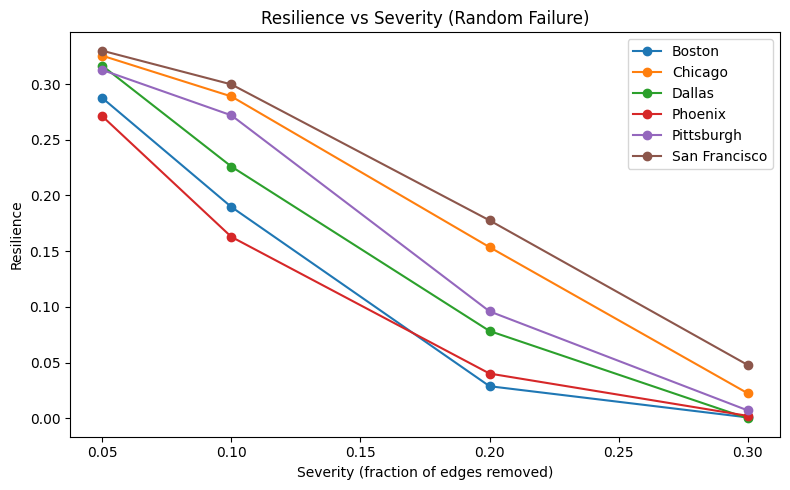

In [2]:
plt.figure(figsize=(8, 5))
for city in cities:
    vals = results_df[
        (results_df.city == city) &
        (results_df.scenario == "Random Failure")
    ].sort_values("severity")

    plt.plot(vals.severity, vals.resilience, marker="o", label=city)

plt.xlabel("Severity (fraction of edges removed)")
plt.ylabel("Resilience")
plt.title("Resilience vs Severity (Random Failure)")
plt.legend()
plt.tight_layout()
plt.show()


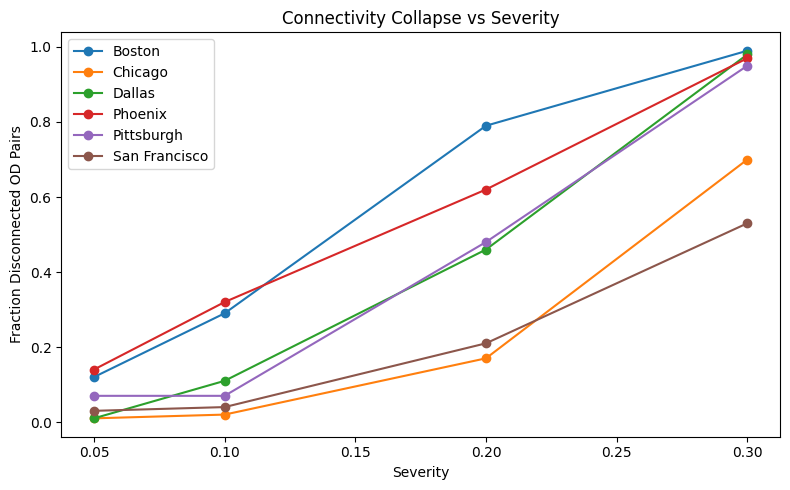

In [3]:
plt.figure(figsize=(8, 5))
for city in cities:
    vals = results_df[
        (results_df.city == city) &
        (results_df.scenario == "Random Failure")
    ].sort_values("severity")

    plt.plot(vals.severity, vals.pct_disconnected, marker="o", label=city)

plt.xlabel("Severity")
plt.ylabel("Fraction Disconnected OD Pairs")
plt.title("Connectivity Collapse vs Severity")
plt.legend()
plt.tight_layout()
plt.show()


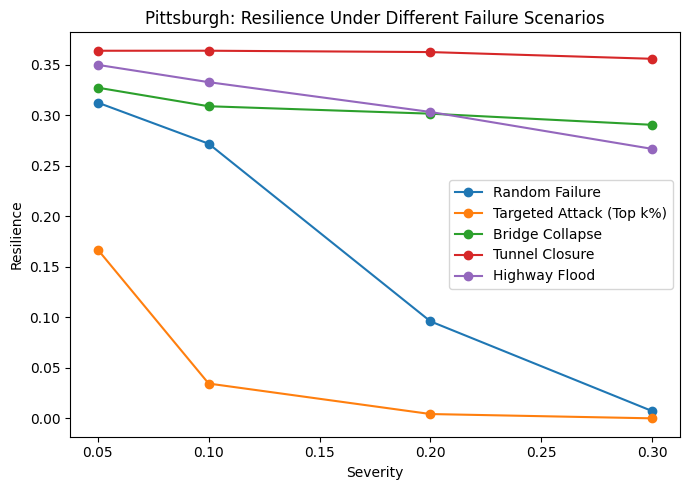

In [4]:
city = "Pittsburgh"
plt.figure(figsize=(7, 5))

for scenario in scenarios:
    vals = results_df[
        (results_df.city == city) &
        (results_df.scenario == scenario)
    ].sort_values("severity")

    plt.plot(vals.severity, vals.resilience, marker="o", label=scenario)

plt.xlabel("Severity")
plt.ylabel("Resilience")
plt.title(f"{city}: Resilience Under Different Failure Scenarios")
plt.legend()
plt.tight_layout()
plt.show()


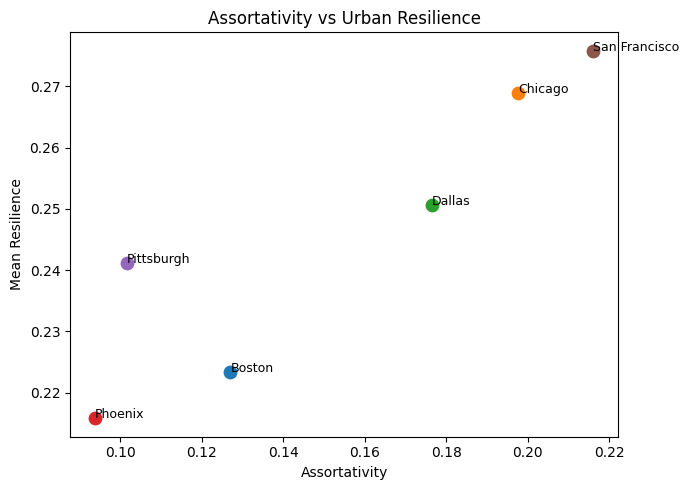

In [5]:
merged = results_df.merge(baseline_df, on="city")

plt.figure(figsize=(7, 5))
for city in cities:
    x = baseline_df.loc[baseline_df.city == city, "assortativity"].values[0]
    y = merged.loc[merged.city == city, "resilience"].mean()
    plt.scatter(x, y, s=80)
    plt.text(x, y, city, fontsize=9)

plt.xlabel("Assortativity")
plt.ylabel("Mean Resilience")
plt.title("Assortativity vs Urban Resilience")
plt.tight_layout()
plt.show()


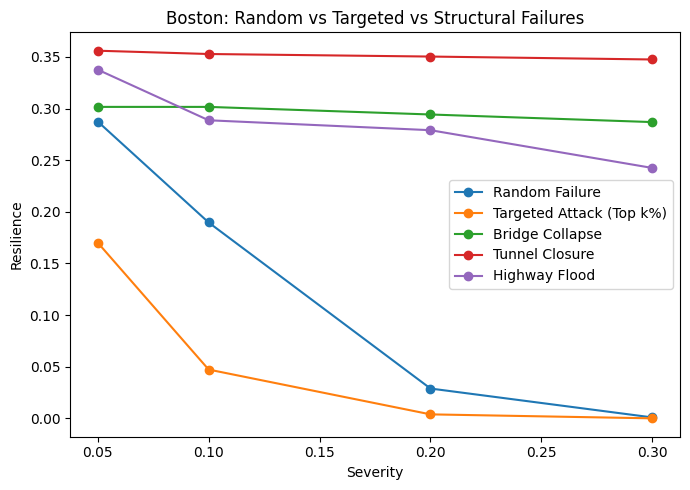

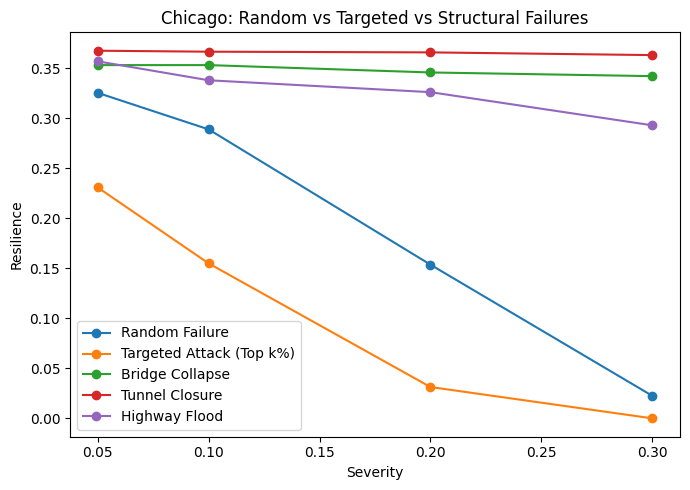

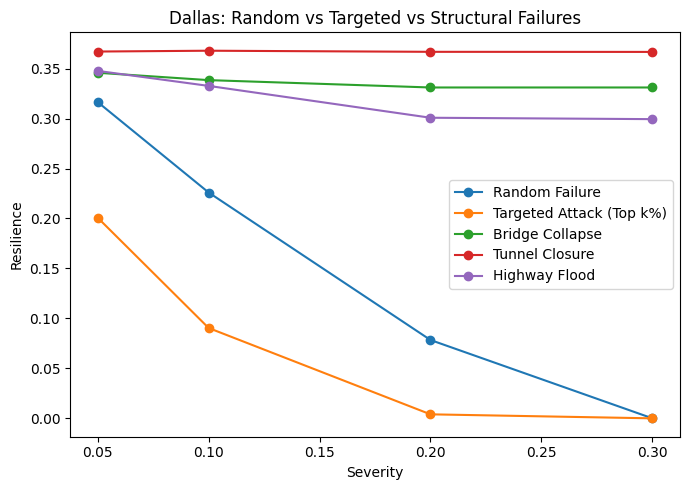

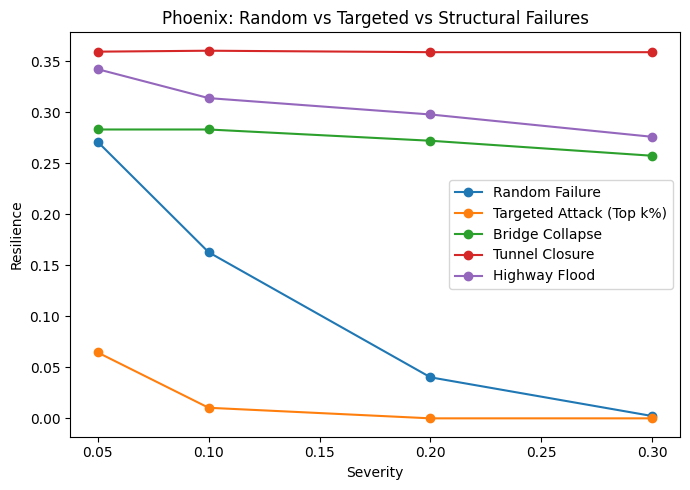

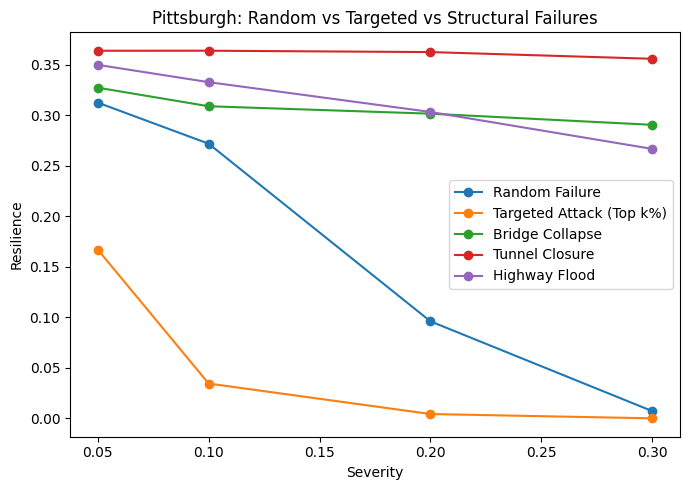

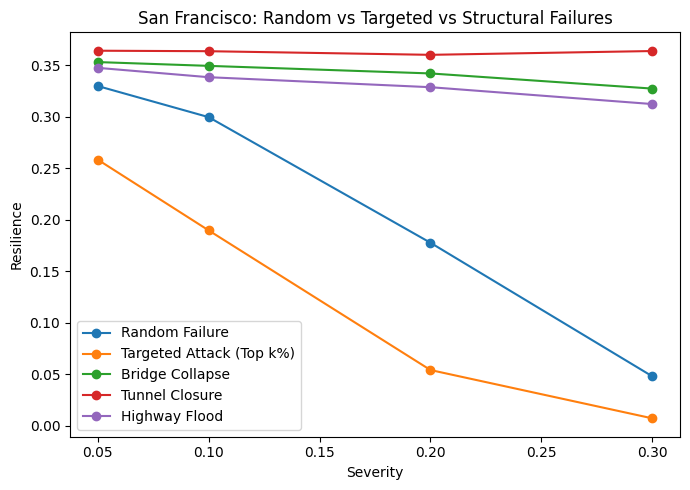

In [6]:
for city in cities:
    plt.figure(figsize=(7, 5))

    for scenario in scenarios:
        vals = results_df[
            (results_df.city == city) &
            (results_df.scenario == scenario)
        ].sort_values("severity")

        plt.plot(
            vals.severity,
            vals.resilience,
            marker="o",
            label=scenario
        )

    plt.xlabel("Severity")
    plt.ylabel("Resilience")
    plt.title(f"{city}: Random vs Targeted vs Structural Failures")
    plt.legend()
    plt.tight_layout()
    plt.show()


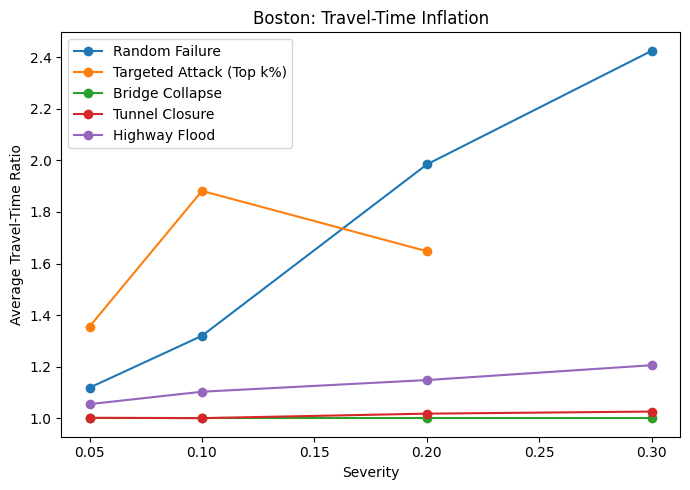

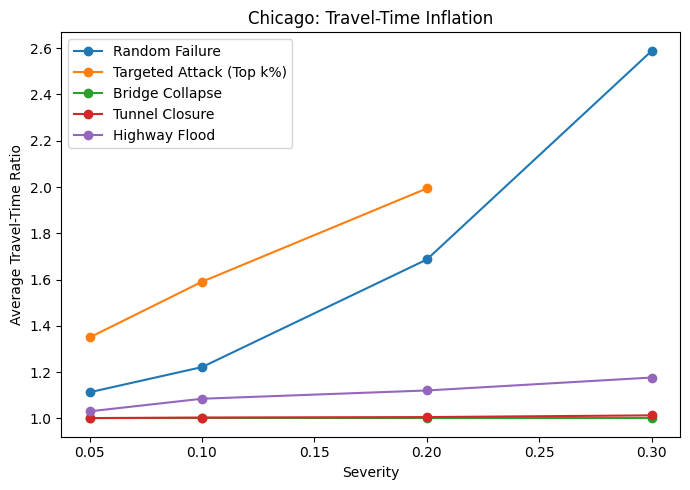

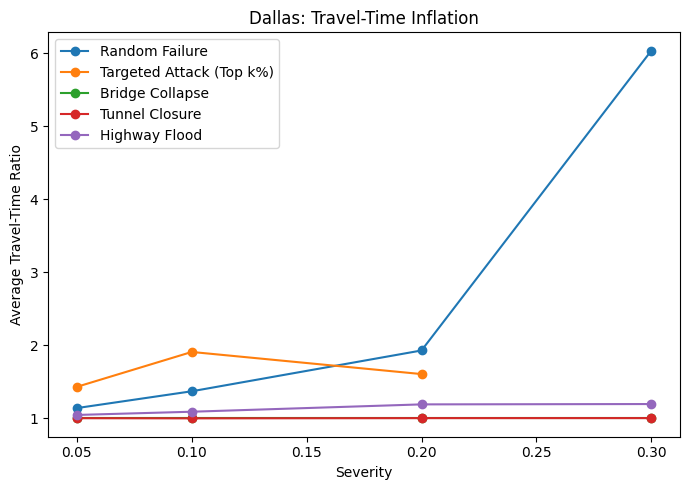

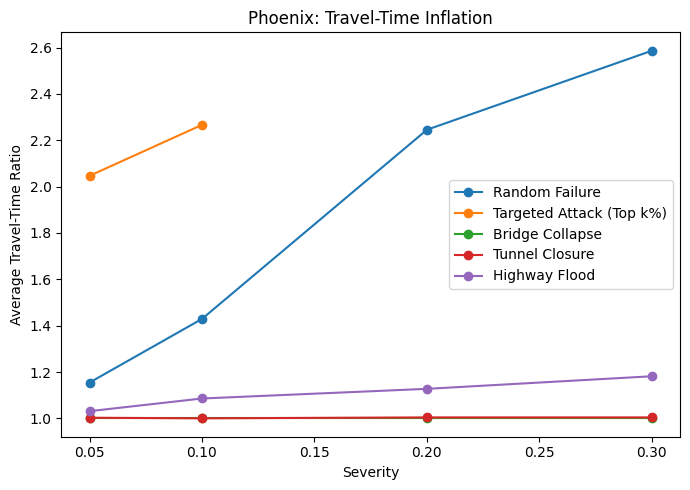

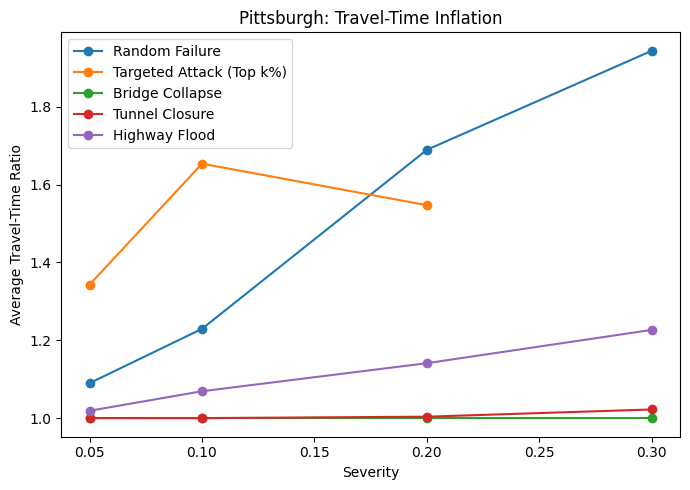

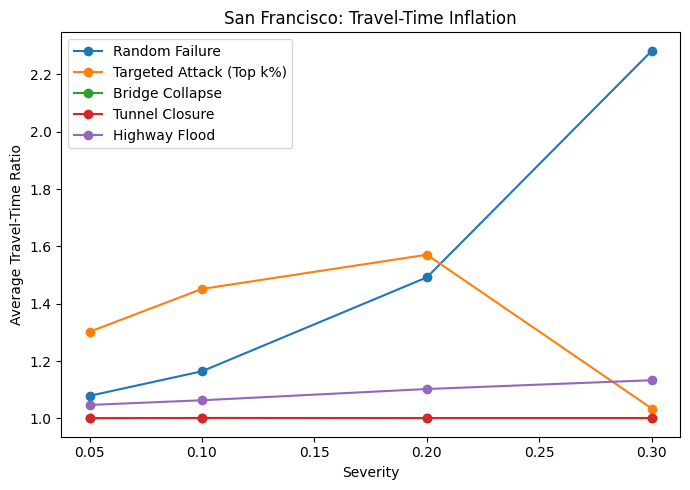

In [7]:
for city in cities:
    plt.figure(figsize=(7, 5))

    for scenario in scenarios:
        vals = results_df[
            (results_df.city == city) &
            (results_df.scenario == scenario)
        ].sort_values("severity")

        plt.plot(vals.severity, vals.avg_ratio, marker="o", label=scenario)

    plt.xlabel("Severity")
    plt.ylabel("Average Travel-Time Ratio")
    plt.title(f"{city}: Travel-Time Inflation")
    plt.legend()
    plt.tight_layout()
    plt.show()


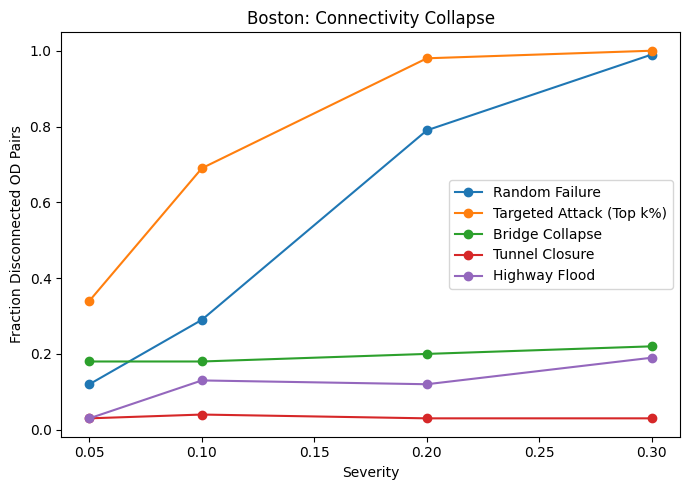

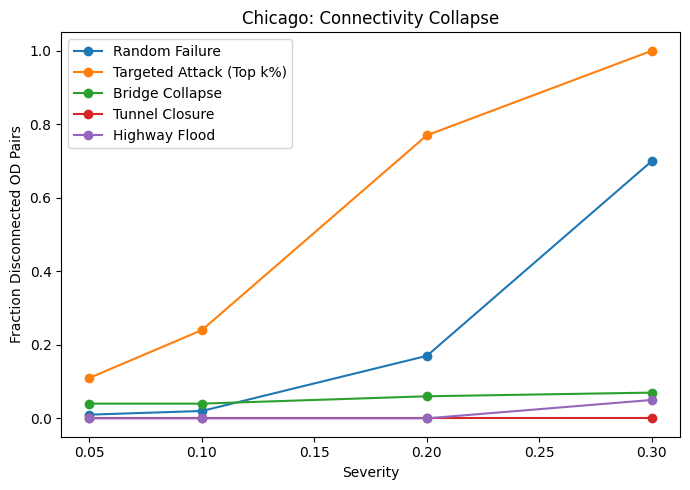

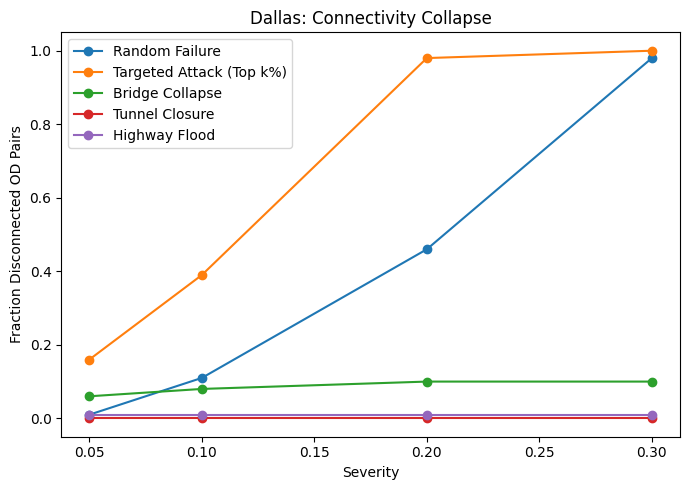

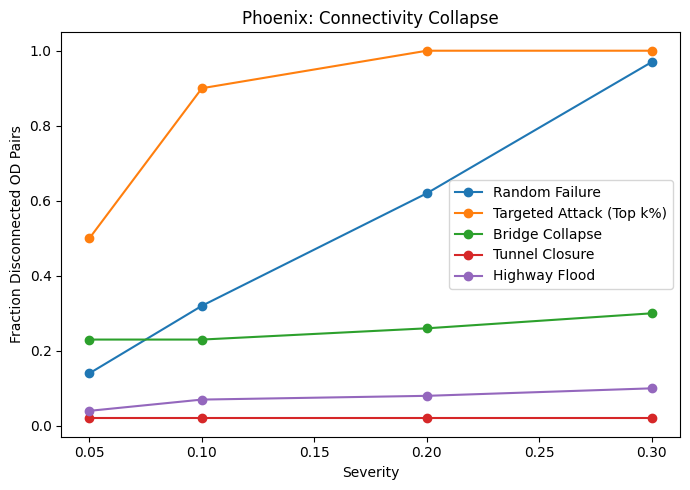

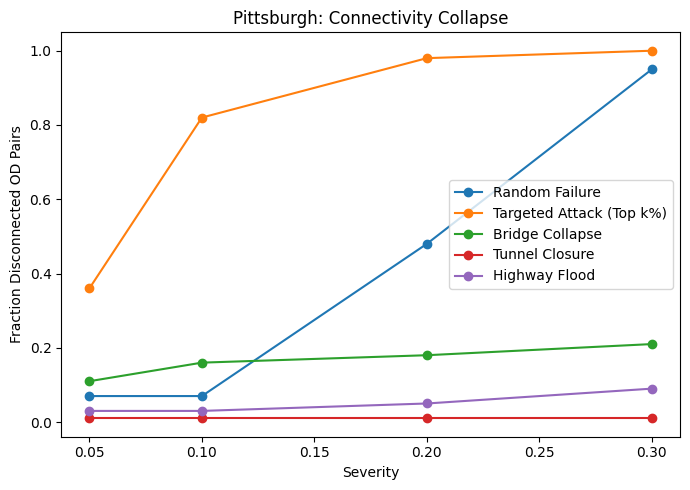

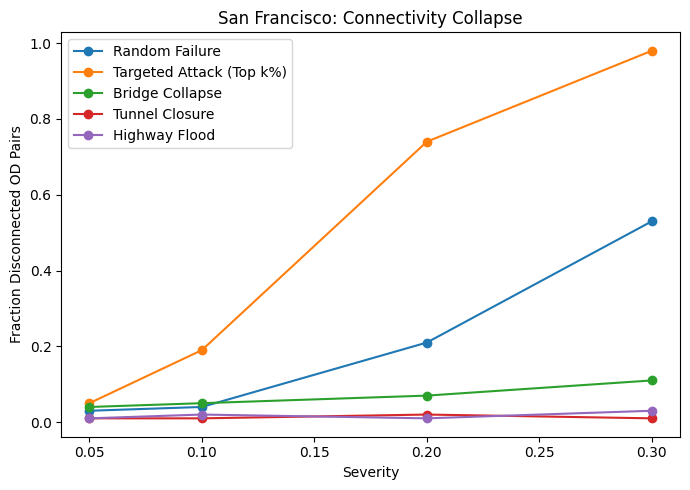

In [8]:
for city in cities:
    plt.figure(figsize=(7, 5))

    for scenario in scenarios:
        vals = results_df[
            (results_df.city == city) &
            (results_df.scenario == scenario)
        ].sort_values("severity")

        plt.plot(vals.severity, vals.pct_disconnected, marker="o", label=scenario)

    plt.xlabel("Severity")
    plt.ylabel("Fraction Disconnected OD Pairs")
    plt.title(f"{city}: Connectivity Collapse")
    plt.legend()
    plt.tight_layout()
    plt.show()


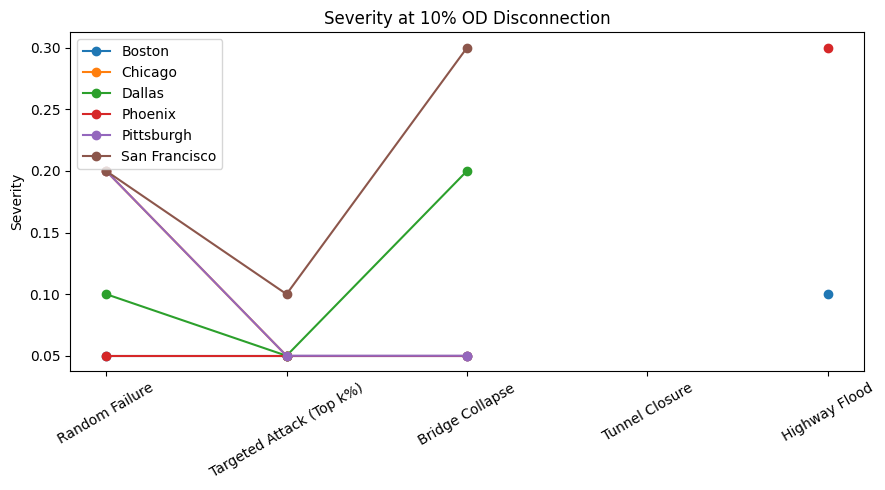

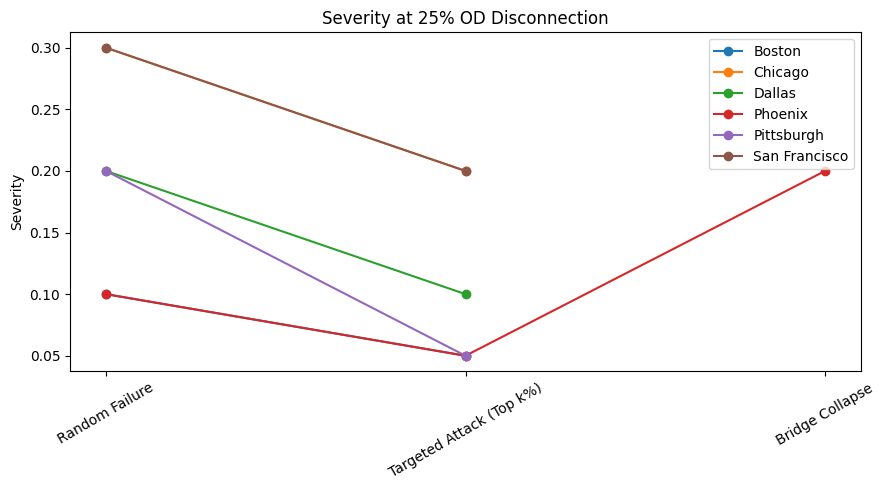

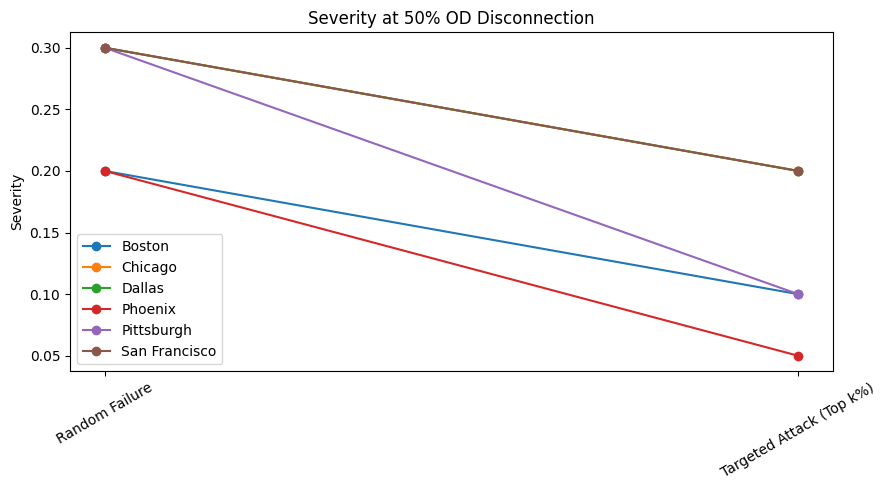

In [9]:
thresholds = [0.1, 0.25, 0.5]
records = []

for city in cities:
    for scenario in scenarios:
        vals = results_df[
            (results_df.city == city) &
            (results_df.scenario == scenario)
        ].sort_values("severity")

        for t in thresholds:
            crossed = vals[vals.pct_disconnected >= t]
            sev = crossed.severity.iloc[0] if not crossed.empty else np.nan
            records.append({
                "city": city,
                "scenario": scenario,
                "threshold": t,
                "severity": sev
            })

threshold_df = pd.DataFrame(records)

for t in thresholds:
    plt.figure(figsize=(9, 5))
    sub = threshold_df[threshold_df.threshold == t]

    for city in cities:
        vals = sub[sub.city == city]
        plt.plot(vals.scenario, vals.severity, marker="o", label=city)

    plt.ylabel("Severity")
    plt.title(f"Severity at {int(t*100)}% OD Disconnection")
    plt.xticks(rotation=30)
    plt.legend()
    plt.tight_layout()
    plt.show()


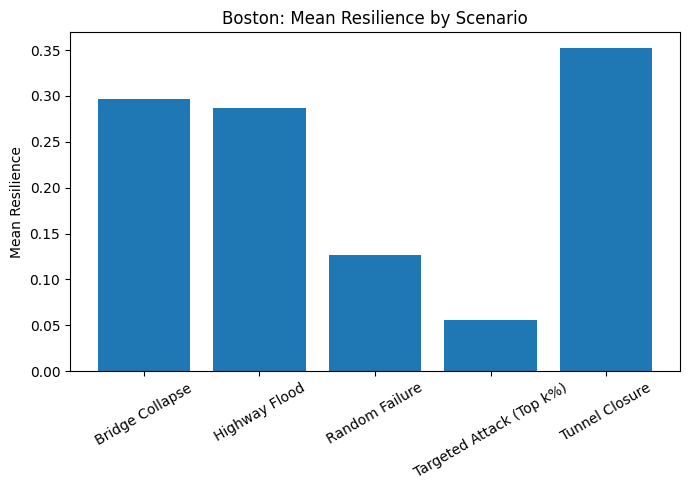

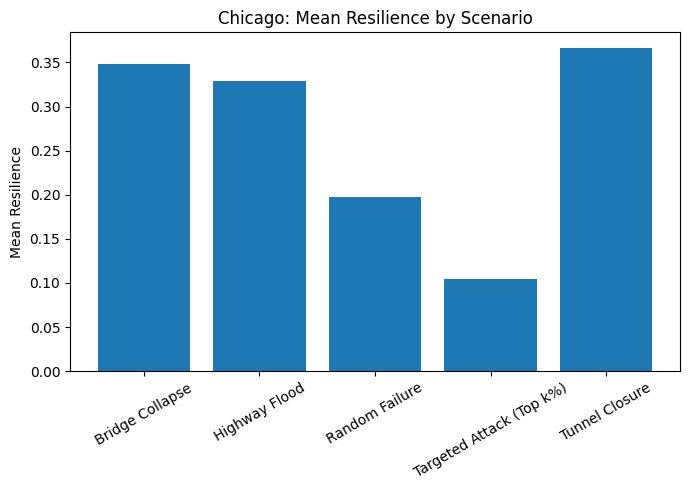

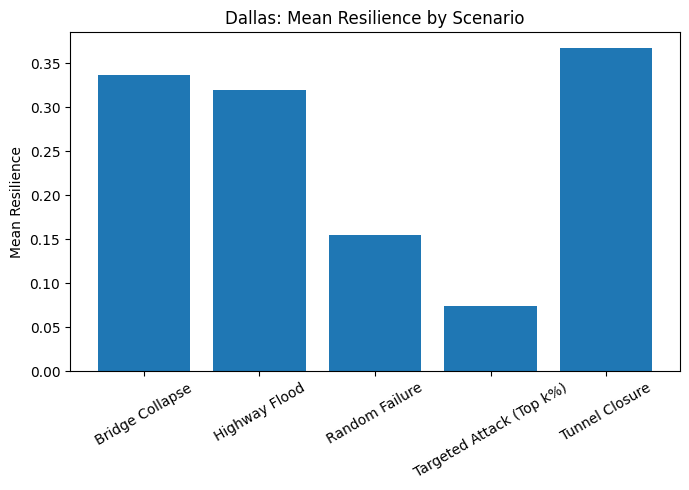

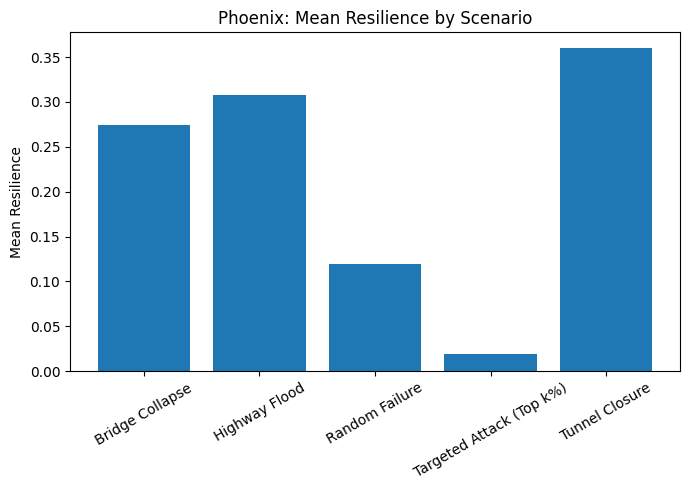

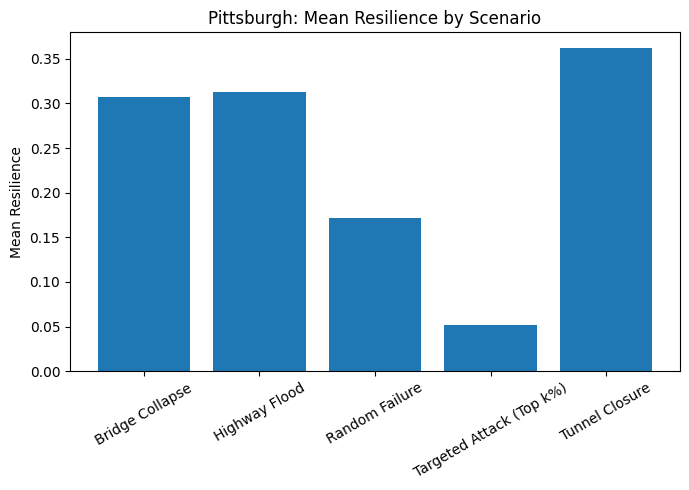

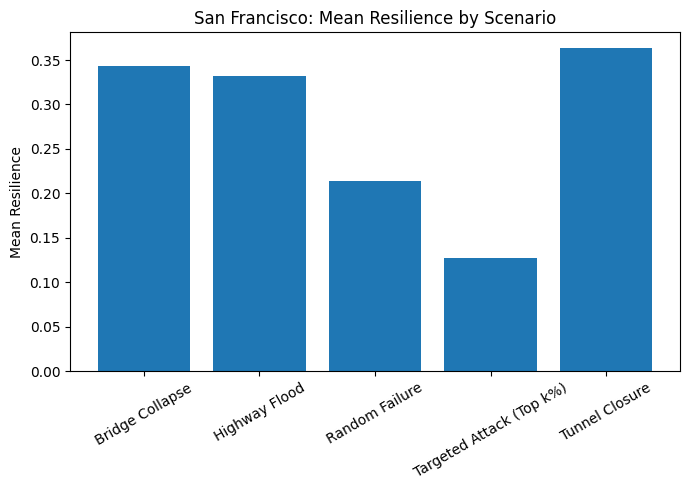

In [10]:
mean_res = (
    results_df
    .groupby(["city", "scenario"])["resilience"]
    .mean()
    .reset_index()
)

for city in cities:
    plt.figure(figsize=(7, 5))
    vals = mean_res[mean_res.city == city]

    plt.bar(vals.scenario, vals.resilience)
    plt.ylabel("Mean Resilience")
    plt.title(f"{city}: Mean Resilience by Scenario")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


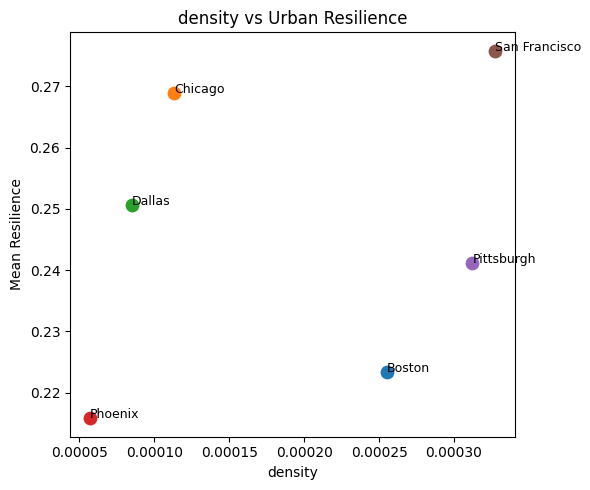

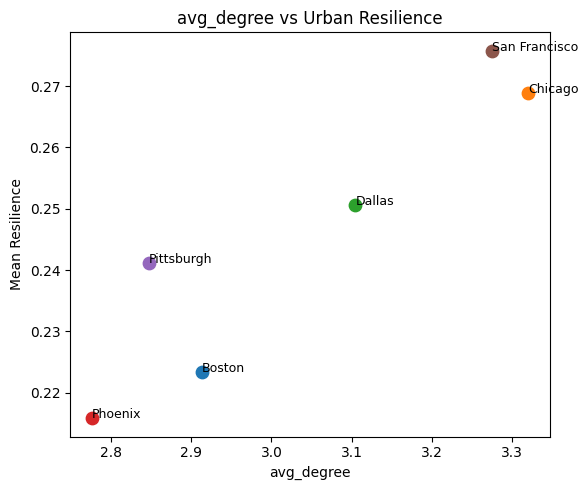

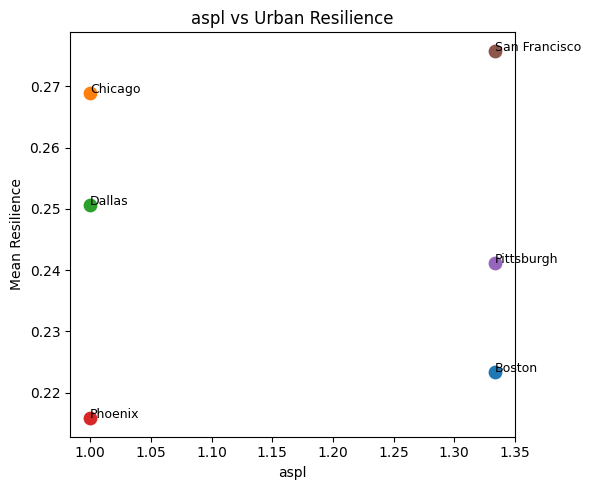

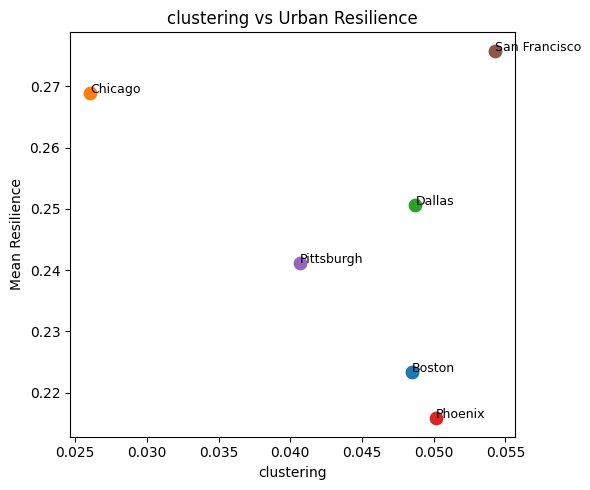

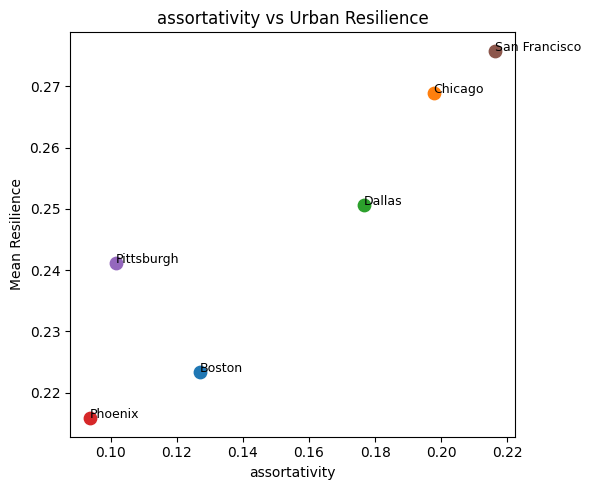

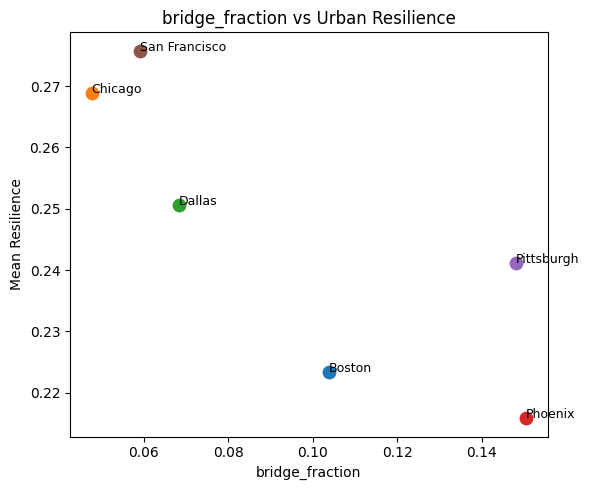

In [11]:
merged = results_df.merge(baseline_df, on="city")
mean_city_res = merged.groupby("city")["resilience"].mean().reset_index()

features = [
    "density",
    "avg_degree",
    "aspl",
    "clustering",
    "assortativity",
    "bridge_fraction"
]

for feat in features:
    plt.figure(figsize=(6, 5))

    for city in cities:
        x = baseline_df.loc[baseline_df.city == city, feat].values[0]
        y = mean_city_res.loc[mean_city_res.city == city, "resilience"].values[0]
        plt.scatter(x, y, s=80)
        plt.text(x, y, city, fontsize=9)

    plt.xlabel(feat)
    plt.ylabel("Mean Resilience")
    plt.title(f"{feat} vs Urban Resilience")
    plt.tight_layout()
    plt.show()


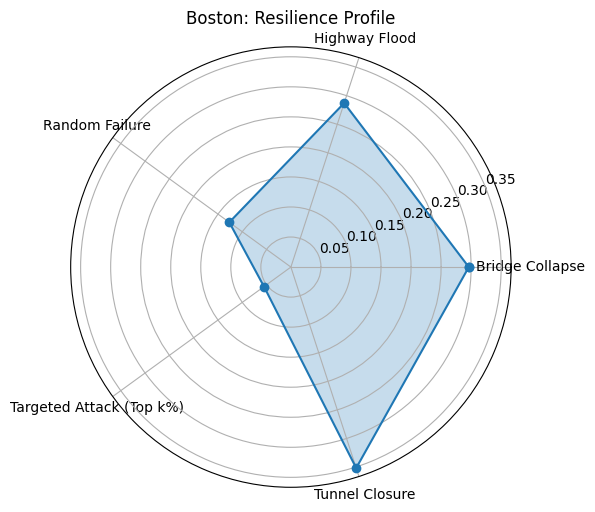

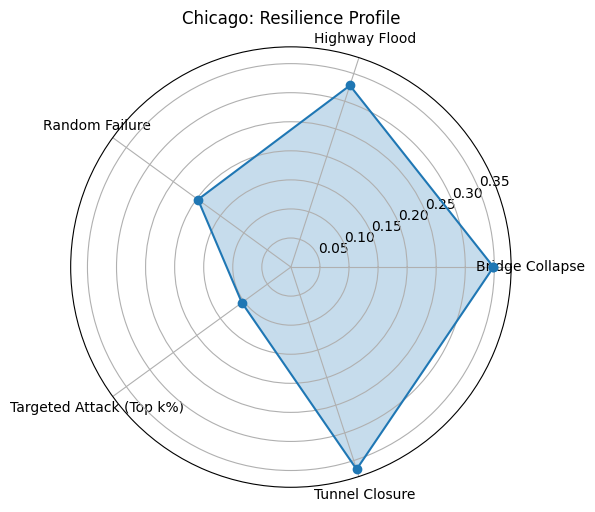

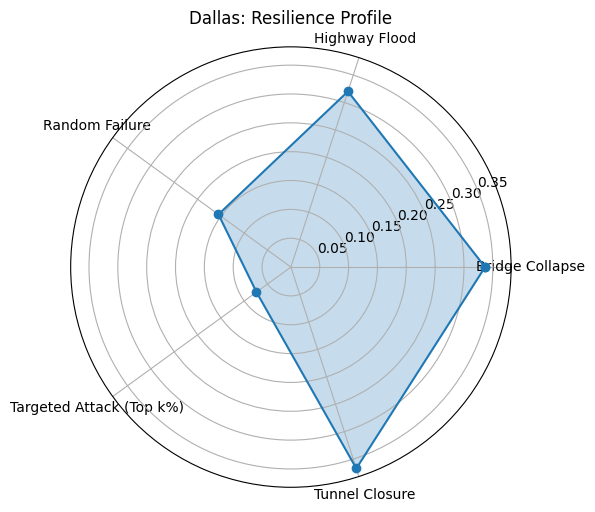

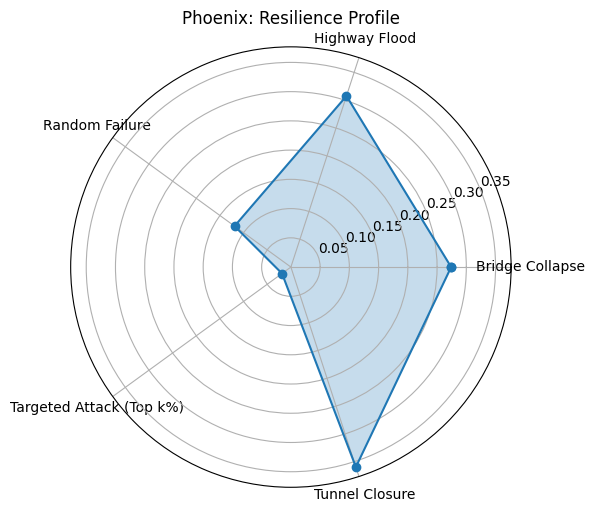

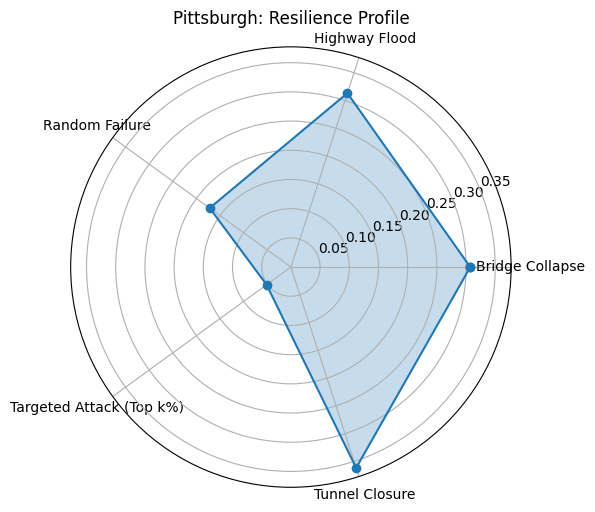

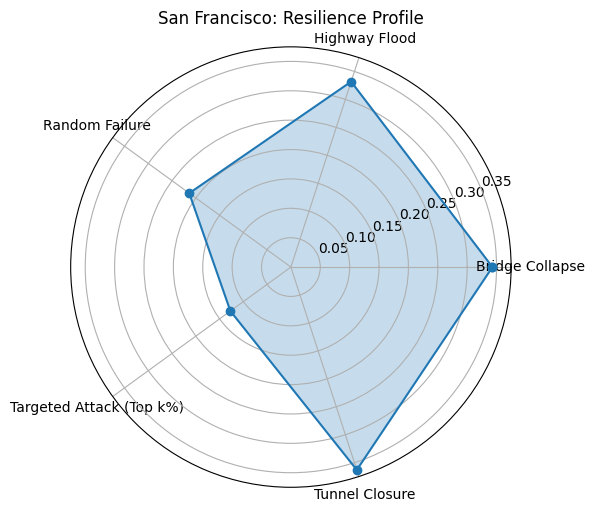

In [12]:
import math

scen_vals = mean_res.pivot(index="city", columns="scenario", values="resilience")

for city in cities:
    vals = scen_vals.loc[city].values
    angles = np.linspace(0, 2 * math.pi, len(vals), endpoint=False)
    vals = np.concatenate([vals, [vals[0]]])
    angles = np.concatenate([angles, [angles[0]]])

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, vals, marker="o")
    ax.fill(angles, vals, alpha=0.25)

    ax.set_thetagrids(angles[:-1] * 180 / math.pi, scen_vals.columns)
    ax.set_title(f"{city}: Resilience Profile")
    plt.tight_layout()
    plt.show()


/var/folders/yj/v8_dnf_j2cv3dhbnc108tr7w0000gn/T/ipykernel_48884/2998022585.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(vals.resilience, vals.severity)


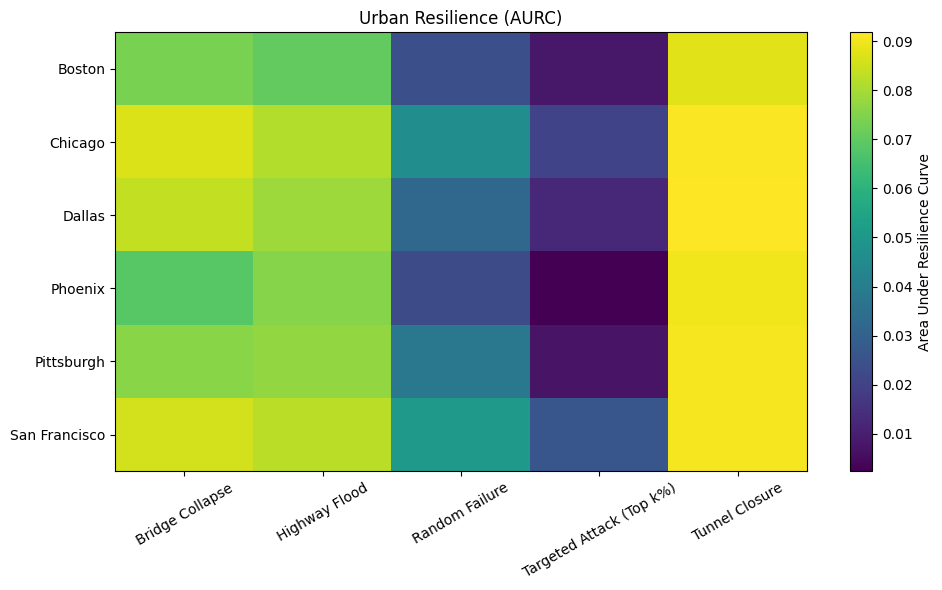

In [13]:
aurc = []

for city in cities:
    for scenario in scenarios:
        vals = results_df[
            (results_df.city == city) &
            (results_df.scenario == scenario)
        ].sort_values("severity")

        area = np.trapz(vals.resilience, vals.severity)
        aurc.append({
            "city": city,
            "scenario": scenario,
            "aurc": area
        })

aurc_df = pd.DataFrame(aurc)
pivot = aurc_df.pivot(index="city", columns="scenario", values="aurc")

plt.figure(figsize=(10, 6))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Area Under Resilience Curve")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=30)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Urban Resilience (AURC)")
plt.tight_layout()
plt.show()


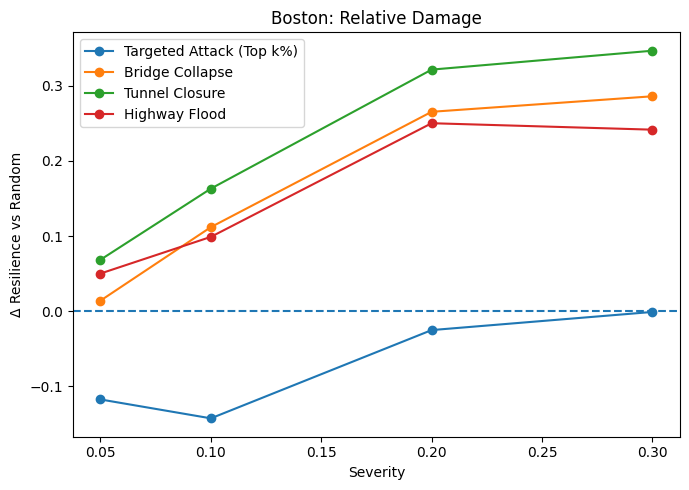

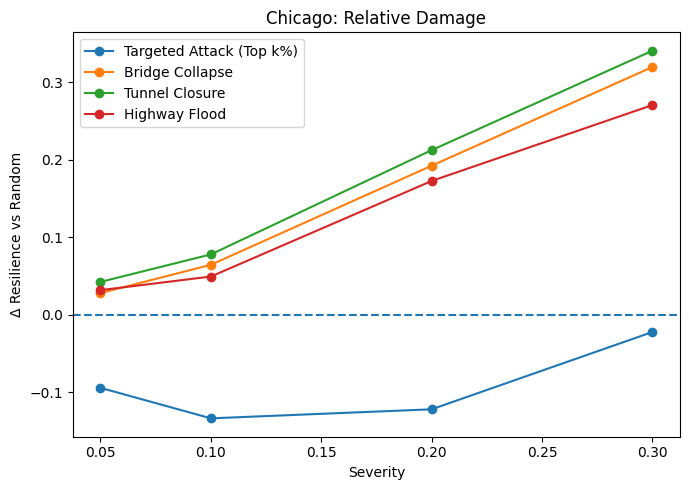

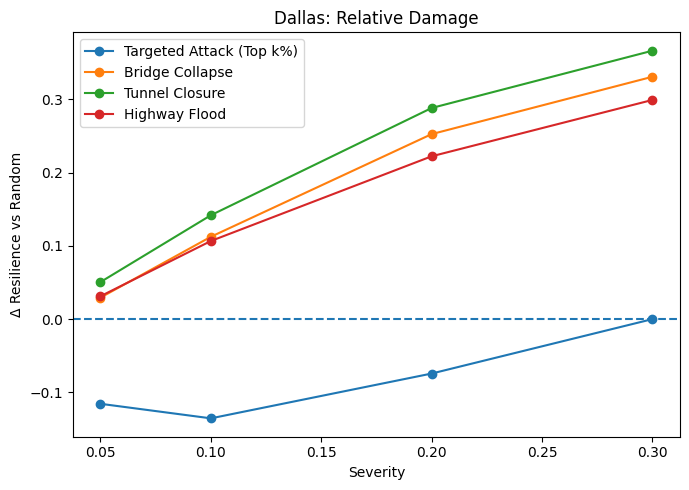

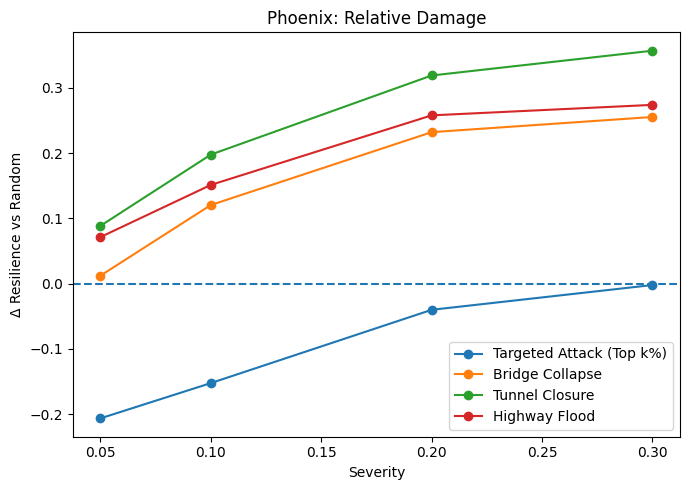

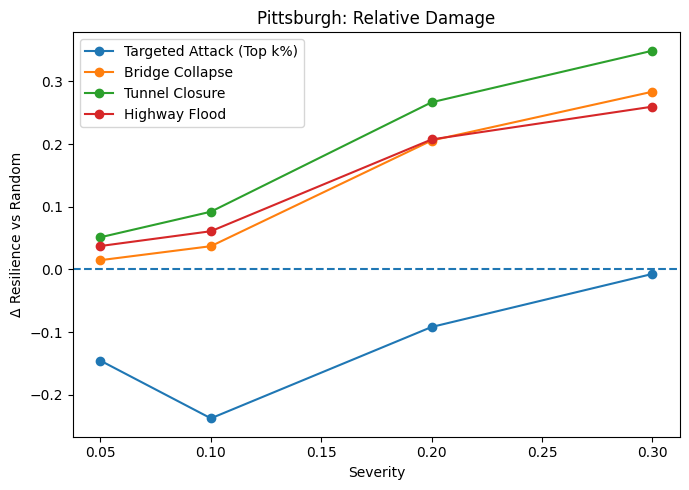

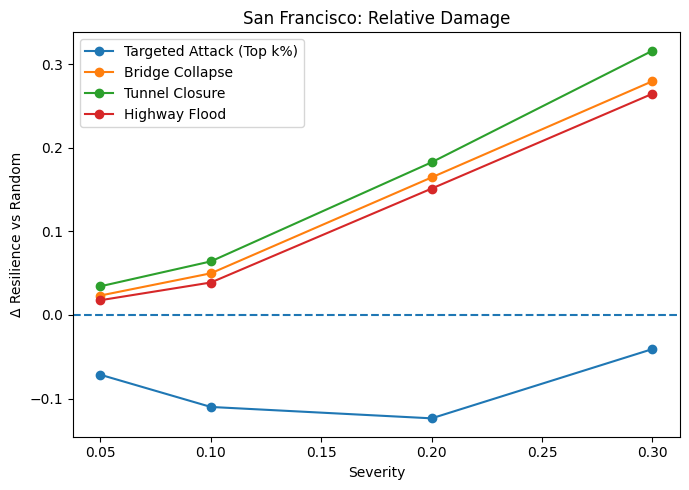

In [14]:
for city in cities:
    plt.figure(figsize=(7, 5))

    base = results_df[
        (results_df.city == city) &
        (results_df.scenario == "Random Failure")
    ].set_index("severity")

    for scenario in scenarios:
        if scenario == "Random Failure":
            continue

        vals = results_df[
            (results_df.city == city) &
            (results_df.scenario == scenario)
        ].set_index("severity")

        delta = vals.resilience - base.resilience
        plt.plot(delta.index, delta.values, marker="o", label=scenario)

    plt.axhline(0, linestyle="--")
    plt.xlabel("Severity")
    plt.ylabel("Δ Resilience vs Random")
    plt.title(f"{city}: Relative Damage")
    plt.legend()
    plt.tight_layout()
    plt.show()
